In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

In [2]:
# hgg_onnx = NanoEventsFactory.from_root(
#     {'inference/test_sig.root':"/Events"},
#     delayed=False,
#     schemaclass=BaseSchema,
#     metadata={'dataset':'test'}
# ).events()

In [3]:
# qcd_onnx = NanoEventsFactory.from_root(
#     {'inference/test_qcd.root':"/Events"},
#     delayed=False,
#     schemaclass=BaseSchema,
#     metadata={'dataset':'test'}
# ).events()

In [4]:
# wqq = NanoEventsFactory.from_root(
#     {'predict_output/test_wqq.root':"/Events"},
#     delayed=False,
#     schemaclass=BaseSchema,
#     metadata={'dataset':'test'}
# ).events()

In [47]:
# file = NanoEventsFactory.from_root(
#     {'inference/test_all_classes.root':"/Events"},
#     delayed=False,
#     schemaclass=BaseSchema,
#     metadata={'dataset':'test'}
# ).events()
# hgg_onnx = file[file.label_H_gg == 1]
# qcd_onnx = file[file.label_QCD == 1]
# wqq_onnx = file[file.label_Wqq == 1]

In [6]:
file = NanoEventsFactory.from_root(
    {'predict_output/output_all_classes.root':"/Events"},
    delayed=False,
    schemaclass=BaseSchema,
    metadata={'dataset':'test'}
).events()
hgg = file[file.label_H_gg == 1]
qcd = file[file.label_QCD == 1]
#wqq = file[file.label_Wqq == 1]

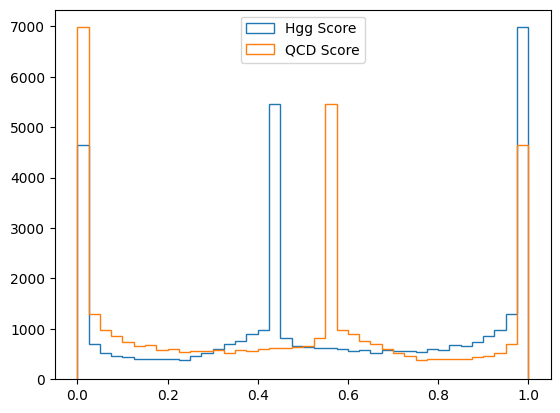

In [7]:
#plt.hist(hgg_onnx.score_label_H_gg, bins=40, histtype='step', density=False, label='Onnx Hgg Score')
#plt.hist(hgg_onnx.score_label_QCD, bins=40, histtype='step', density=False, label='Onnx QCD Score')
plt.hist(hgg.score_label_H_gg, bins=40, histtype='step', density=False, label='Hgg Score')
plt.hist(hgg.score_label_QCD, bins=40, histtype='step', density=False, label='QCD Score')
#plt.hist(hgg.score_label_Wqq, bins=40, histtype='step', density=False, label='Wqq Score')
plt.legend()
plt.show()

In [8]:
#plt.hist(qcd_onnx.score_label_H_gg, bins=40, histtype='step', density=False, label='Onnx Hgg Score')
#plt.hist(qcd_onnx.score_label_QCD, bins=40, histtype='step', density=False, label='Onnx QCD Score')
# plt.hist(qcd.score_label_H_gg, bins=40, histtype='step', density=False, label='Hgg Score')
# plt.hist(qcd.score_label_QCD, bins=40, histtype='step', density=False, label='QCD Score')
#plt.hist(qcd.score_label_Wqq, bins=40, histtype='step', density=False, label='Wqq Score')
# plt.legend()
# plt.show()

In [9]:
# plt.hist(wqq.score_label_H_gg, bins=40, histtype='step', density=False, label='Hgg Score')
# plt.hist(wqq.score_label_QCD, bins=40, histtype='step', density=False, label='QCD Score')
# plt.hist(wqq.score_label_Wqq, bins=40, histtype='step', density=False, label='Wqq Score')
# plt.legend()
# plt.show()

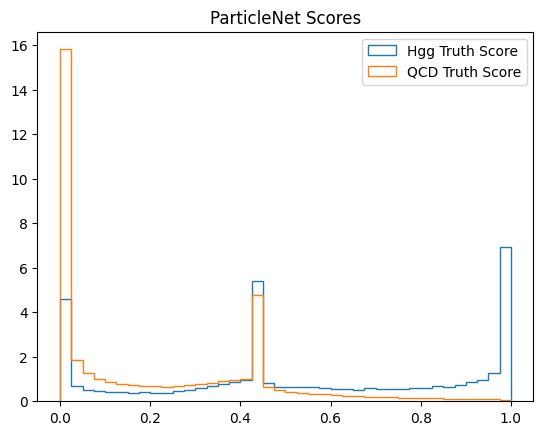

In [10]:
plt.hist(hgg.score_label_H_gg, bins=40, histtype='step', density=True, label='Hgg Truth Score')
plt.hist(qcd.score_label_H_gg, bins=40, histtype='step', density=True, label='QCD Truth Score')
#plt.hist(wqq.score_label_H_gg, bins=40, histtype='step', density=True, label='Wqq Truth Score')
plt.legend()
plt.title('ParticleNet Scores')
plt.show()

In [11]:
# plt.hist(hgg.score_label_QCD, bins=40, histtype='step', density=True, label='Hgg QCD Score')
# plt.hist(qcd.score_label_QCD, bins=40, histtype='step', density=True, label='QCD QCD Score')
#plt.hist(wqq.score_label_QCD, bins=40, histtype='step', density=True, label='Wqq QCD Score')
# plt.legend()
# plt.show()

In [12]:
# plt.hist(hgg.score_label_Wqq, bins=40, histtype='step', density=True, label='Hgg Wqq Score')
# plt.hist(qcd.score_label_Wqq, bins=40, histtype='step', density=True, label='QCD Wqq Score')
# plt.hist(wqq.score_label_Wqq, bins=40, histtype='step', density=True, label='Wqq Wqq Score')
# plt.legend()
# plt.show()

In [13]:
def roc_and_wps(signal_score, bkg_score):
    bkg_zeros = ak.zeros_like(bkg_score)
    sig_ones = ak.ones_like(signal_score)
    combined = ak.concatenate([bkg_score,signal_score])
    combined_truth = ak.concatenate([bkg_zeros, sig_ones])

    fpr, tpr, thresholds = roc_curve(combined_truth, combined)
    roc_auc = auc(fpr, tpr)

    hrange=(0,1)

    hgg_hist = np.histogram(signal_score, bins=20,
                    range=hrange
                    )
    qcd_hist = np.histogram(bkg_score, bins=20, 
                     range=hrange
                    )

    sig_sums = []
    for i in range(len(hgg_hist[0])+1):
        sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))
    
    bkg_sums = []
    for i in range(len(qcd_hist[0])+1):
        bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

    sig_ratios = []
    for i in sig_sums:
        sig_ratios.append(i/sig_sums[-1])
    bkg_ratios = []
    for i in bkg_sums:
        bkg_ratios.append(i/bkg_sums[-1])

    wp_ratios = {}
    for i in range(len(hgg_hist[1])):
        wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

    plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
    plt.xlim([0, 1.0])
    #     ax.set_ylim([1e-5, 1.0])

    plt.title(f"Hgg receiver operating curve ParticleNet")
    plt.legend(loc="lower right")
    plt.axvline(x=0.5, color='black')
    plt.axhline(y=0.5, color='black')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    # plt.yscale('log')
    # plt.xlabel("True positive rate")
    # plt.ylabel("False positive rate")
    # plt.axvline(x=0.25, color='red')
    # plt.axhline(y=2.8e-3, color='red')
    # plt.axvline(x=0.2, color='blue')
    # plt.axhline(y=1.4e-4, color='blue')
    for i in wp_ratios:
        plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {float(i):.2f}')
    plt.legend(bbox_to_anchor=(1.05,1.05))
    plt.show()

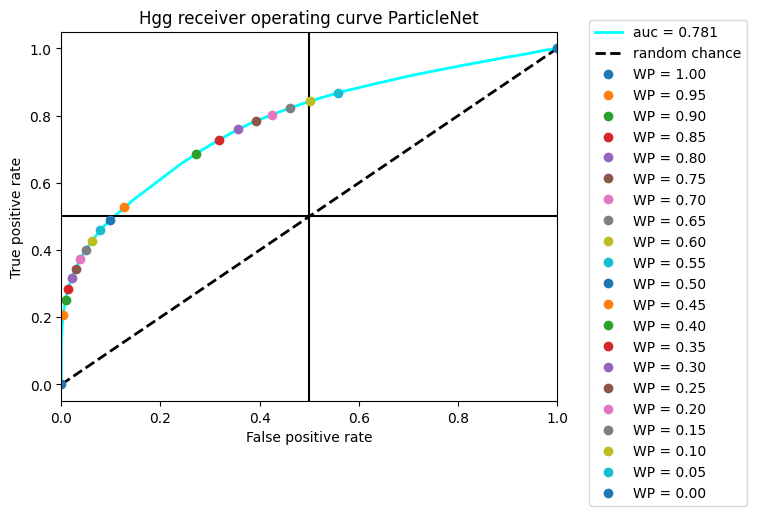

In [14]:
roc_and_wps(hgg.score_label_H_gg, qcd.score_label_H_gg)

In [15]:
def get_percentile_cut(data, target_percentile=0.20):
    data = np.array(data)
    cut_value = np.percentile(data, (1 - target_percentile) * 100)
    return cut_value

In [16]:
cut = get_percentile_cut(hgg.score_label_H_gg)
cut
#cut = 0.95

0.9549544930458069

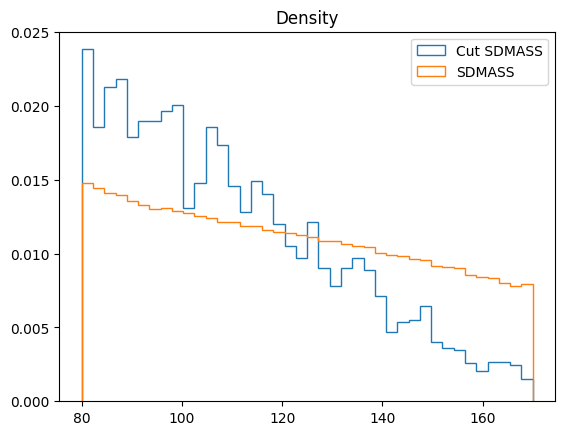

In [17]:
plt.hist(qcd.fj_sdmass[qcd.score_label_H_gg > cut], bins=40, histtype='step', density=True, label='Cut SDMASS')
plt.hist(qcd.fj_sdmass, bins=40, histtype='step', density=True, label='SDMASS')
plt.legend()
plt.title('Density')
plt.show()

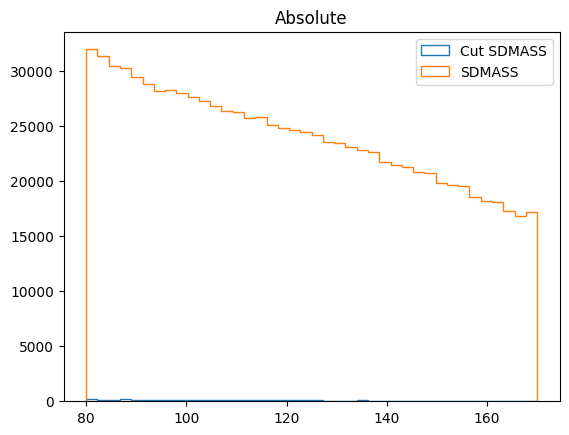

In [18]:
plt.hist(qcd.fj_sdmass[qcd.score_label_H_gg > cut], bins=40, histtype='step', density=False, label='Cut SDMASS')
plt.hist(qcd.fj_sdmass, bins=40, histtype='step', density=False, label='SDMASS')
plt.legend()
plt.title('Absolute')
plt.show()

In [19]:
len(qcd.fj_sdmass[qcd.score_label_H_gg > cut]) / len(qcd.fj_sdmass) * 100

0.34278672410604255

In [20]:
# plt.hist(wqq.fj_sdmass[wqq.score_label_H_gg > cut], bins=40, histtype='step', density=True, label='Cut SDMASS')
# plt.hist(wqq.fj_sdmass, bins=40, histtype='step', density=True, label='SDMASS')
# plt.legend()
# plt.show()

In [21]:
# plt.hist(wqq.fj_sdmass[wqq.score_label_H_gg > cut], bins=40, histtype='step', density=False, label='Cut SDMASS')
# plt.hist(wqq.fj_sdmass, bins=40, histtype='step', density=False, label='SDMASS')
# plt.legend()
# plt.show()

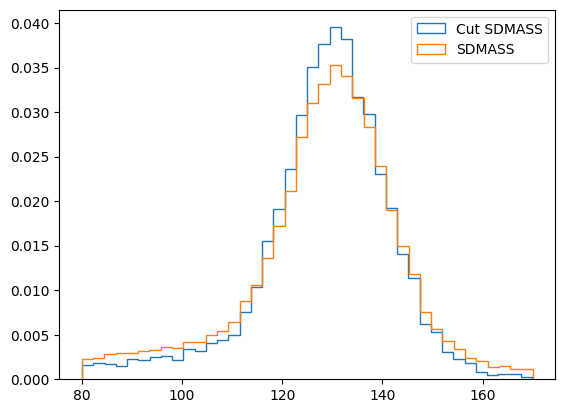

In [22]:
plt.hist(hgg.fj_sdmass[hgg.score_label_H_gg > cut], bins=40, histtype='step', density=True, label='Cut SDMASS')
plt.hist(hgg.fj_sdmass, bins=40, histtype='step', density=True, label='SDMASS')
plt.legend()
plt.show()

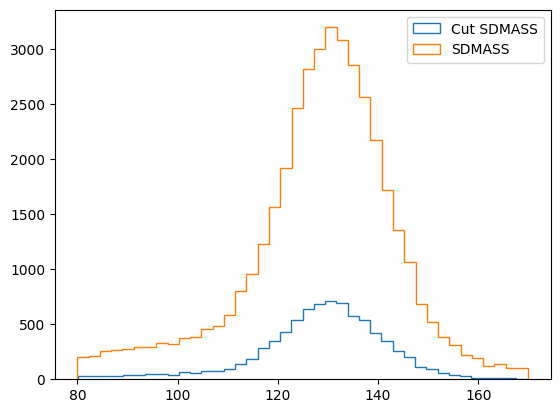

In [23]:
plt.hist(hgg.fj_sdmass[hgg.score_label_H_gg > cut], bins=40, histtype='step', density=False, label='Cut SDMASS')
plt.hist(hgg.fj_sdmass, bins=40, histtype='step', density=False, label='SDMASS')
plt.legend()
plt.show()

In [24]:
def LossPlot(train_log, title='Loss Curve', trend=False):
    ifile = open(train_log, "r")
    loss_values = []
    validation_values = []
    for line in ifile:
        if ("Train" in line) and  ("AvgLoss" in line):
            loss = line.split(", AvgAcc")
            loss = loss[0].split("AvgLoss: ")
            loss_values.append(float(loss[1]))
        if ("Evaluation" in line) and ("AvgLoss" in line):
            val_loss = line.split(", AvgAcc")
            val_loss = val_loss[0].split("AvgLoss: ")
            validation_values.append(float(val_loss[1]))
    # print(loss_values)
    # print(validation_values)
    if trend == False:
        #x = [4 + i for i in range(len(loss_values))]
        plt.plot(np.array(loss_values), label="Training Loss")
        plt.plot(np.array(validation_values), label="Validation Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        #plt.axhline(y=0.30, color='black')
        plt.legend(bbox_to_anchor=(1,1), loc="best")
        plt.title(title)
        plt.savefig('output/loss.png', bbox_inches='tight')
    else:
        loss_trend = []
        for i in range(0,len(loss_values)-1):
            loss_trend.append(loss_values[i+1]-loss_values[i])
  #      print(loss_trend)
        plt.plot(np.array(loss_trend))
    #    plt.plot([0, 0], [len(loss_trend), 0], linestyle="--", lw=2, color="k", label="Random Chance")
        plt.axhline(y=0, linestyle="--", lw=2, color="k", label="Random Chance")
        plt.ylabel("Loss Trend")
        plt.xlabel("Epoch")
        plt.title(title)
        plt.savefig('output/loss.png', bbox_inches='tight')

In [25]:
# Accuracy Plot

def AccPlot(train_log, title='Accuracy Curve'):
    ifile = open(train_log, "r")
    acc_values = []
    validation_values = []
    for line in ifile:
        if ("Train" in line) and ("AvgAcc" in line):
            acc = line.split("AvgAcc: ")
            acc_values.append(float(acc[1]))
        if "Current validation metric" in line:
            val_acc = line.split(" (best")
            val_acc = val_acc[0].split("metric: ")
            validation_values.append(float(val_acc[1]))
    # print(acc_values)
    # print(validation_values)
  #  print(loss_values)
    #x = [4 + i for i in range(len(acc_values))]
    plt.plot(np.array(acc_values), label="Training Accuracy")
    plt.plot(np.array(validation_values), label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    #plt.axhline(y=0.85, color='black')
    plt.legend(bbox_to_anchor=(1,0.175), loc="best")
    plt.title(title)
    plt.savefig('output/acc.png', bbox_inches='tight')


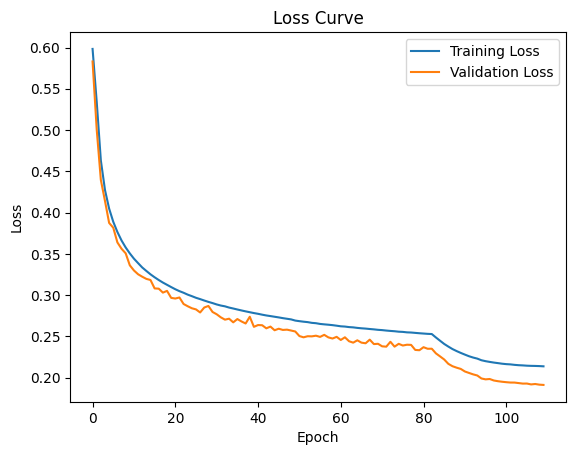

In [28]:
LossPlot("/scratch365/cmoore24/weaver-core/my_attempt/output/train.log", "Loss Curve")

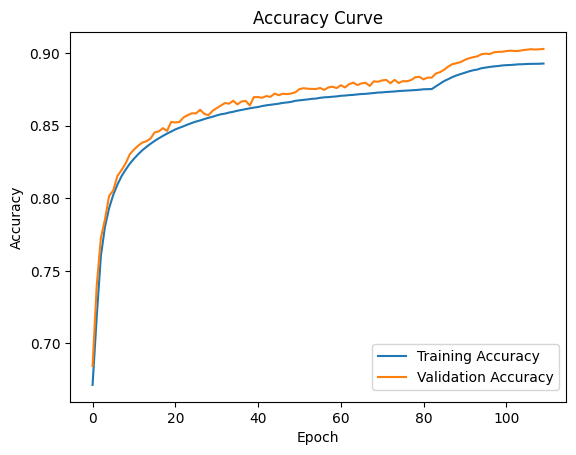

In [29]:
AccPlot("/scratch365/cmoore24/weaver-core/my_attempt/output/train.log", "Accuracy Curve")